In [79]:
##運動実行のデータからCSPフィルタを形成,運動想起の特徴を抽出してみる
#import library
import os
import numpy as np
import scipy.io
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne.decoding import CSP
import mne
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#filePath = '/Users/yamamotokouhei/subjectsData/data20221122'
filePath = '/Users/yamamotokouhei/subjectsData/braindata20221003'
#filePath = '/Users/yamamotokouhei/subjectsData/data20230111'

brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data65_label2 = list()#label2のデータ
o_data65_label3 = list()#label3のデータ
o_data65_label4 = list()#label4のデータ
o_data = list()
label_data = list()#labelを結合したデータ
task1_data = list()
task2_data = list()

All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
[' EEG_grasping_03-Oct-2022_sub1-1.mat', ' EEG_grasping_03-Oct-2022_sub1-2.mat', ' EEG_grasping_03-Oct-2022_sub1-3.mat', ' EEG_grasping_03-Oct-2022_sub2-1.mat', ' EEG_grasping_03-Oct-2022_sub2-2.mat', ' EEG_grasping_03-Oct-2022_sub2-3.mat', ' EEG_grasping_03-Oct-2022_sub3-2.mat', ' EEG_grasping_03-Oct-2022_sub3-3.mat', ' EEG_grasping_03-Oct-2022_sub4-1.mat', ' EEG_grasping_03-Oct-2022_sub4-2.mat', ' EEG_grasping_03-Oct-2022_sub4-3.mat', 'EEG_grasping_03-Oct-2022_sub3-1.mat']


In [80]:
#運動想起の読み込み
#label1の設定
file_name1 = [file_name[6],file_name[7],file_name[11]]
file_num1 = len(file_name1)
#label2の設定
file_name2 = [file_name[8],file_name[9],file_name[10]]
file_num2 = len(file_name2)
# 変数など
trial_num = 30
all_trial = len(file_name1)+len(file_name2) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label2.append(o_data)
print("image data_loading")

image data_loading


In [81]:
c1 = o_data65_label1[0].eeg[: , :1024*12]
c2 = o_data65_label2[0].eeg[: , :1024*12]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , :1024*12]
    g2 = o_data65_label2[n+1].eeg[: , :1024*12]
    c1 = np.dstack([c1, g1])
    c2 = np.dstack([c2, g2])


In [82]:
all_data = np.dstack([c1, c2])
all_data = all_data.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(180, 64, 12288)


In [83]:
#運動実行の読み込み
#label1の設定
mov_file_name1 = [file_name[0],file_name[1],file_name[2]]
mov_file_num1 = len(mov_file_name1)
#label2の設定
mov_file_name2 = [file_name[3],file_name[4],file_name[5]]
mov_file_num2 = len(mov_file_name2)
# 変数など
trial_num = 30
all_trial = len(mov_file_name1)+len(mov_file_name2) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+mov_file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label3.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filePath+"/"+mov_file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label4.append(o_data)
print("image data_loading")

image data_loading


In [84]:
c1 = o_data65_label3[0].eeg[: , :1024*12]
c2 = o_data65_label4[0].eeg[: , :1024*12]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label3[n+1].eeg[: , :1024*12]
    g2 = o_data65_label4[n+1].eeg[: , :1024*12]
    c1 = np.dstack([c1, g1])
    c2 = np.dstack([c2, g2])


In [85]:
all_data2 = np.dstack([c1, c2])
all_data2 = all_data2.transpose(2,0,1)
print(np.shape(all_data2))
mov_all_data = all_data2.astype(np.double)

(180, 64, 12288)


In [86]:
#ラベル生成
label = np.zeros(180,dtype=int)
label[90:] = 1
# a = list()
# b = list() 
# for n in range(len(file_name1)*trial_num):  # all_trial
#     label1 = o_data65_label1[n].label
#     label2 = o_data65_label2[n].label
#     if label1 == 2:
#         label1 = 0
#     if label2 == 2:
#         label2 = 0
#     a.append(label1)
#     b.append(label2)
# label = a+b

In [87]:
label = np.array(label)

In [88]:
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [89]:
# #preprocessing
filter3 = signal.firwin(numtaps=51, cutoff=[2, 30], fs=1024, pass_zero=False)
for i in range(180):
    for j in range(64):
        all_data[i][j] = signal.lfilter(filter3, 1, all_data[i][j][:])
        all_data[i][j] = Standardization(all_data[i][j][:])
        mov_all_data[i][j] = signal.lfilter(filter3, 1, mov_all_data[i][j][:])
        mov_all_data[i][j] = Standardization(mov_all_data[i][j][:])
# for i in range(180):
#     for j in range(64):
#         all_data[i][j] = Standardization(all_data[i][j][:])


In [90]:
train = mov_all_data[:,:,1024*6:1024*12]
test = all_data[:,:,1024*6:1024*12]
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(train)

In [91]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=4, log=None, reg=None, norm_trace=False,cov_est='epoch')
csp = CSP(n_components=4, log=None, reg=None)
# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, train, label, cv=cv, n_jobs=None)
print(scores)

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 64 dim * 7.7e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 64 dim * 7.4e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 64 dim * 7.7e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 64 dim * 7.2e+14  max singular value)
    Estimated rank (

In [92]:
n_channels = 64
sampling_freq = 1024  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('biosemi64')


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

Classification accuracy: 0.955556 / Chance level: 0.500000
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 64 dim * 8.5e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 64 dim * 8.2e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 64 dim * 8.5e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps *

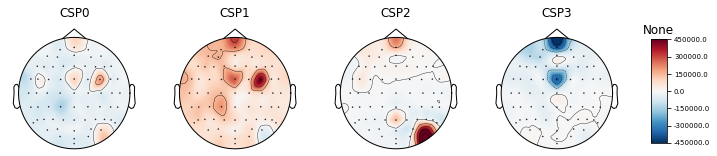

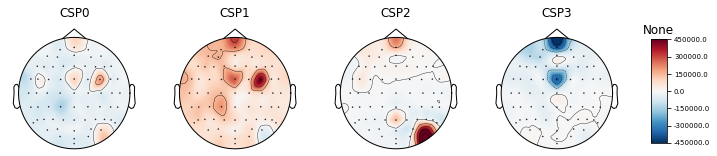

In [93]:
# Printing the results
class_balance = np.mean(label == label[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
kenshou = csp.fit_transform(train, label)
csp.fit_transform(train, label)
csp.plot_patterns(info,ch_type='eeg', units='None', size=1.5)

(180, 4)


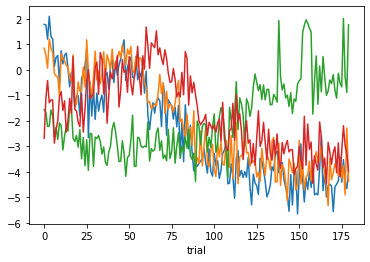

In [94]:
print(np.shape(kenshou))
plt.xlabel('trial')
plt.plot(kenshou)

(180, 4)


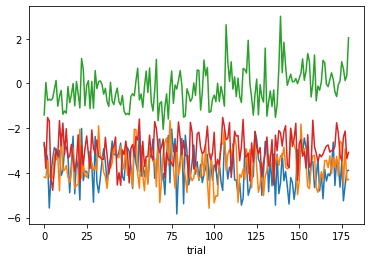

In [95]:
basac = csp.transform(test)
print(np.shape(basac))
plt.xlabel('trial')
plt.plot(basac)

(180, 4)


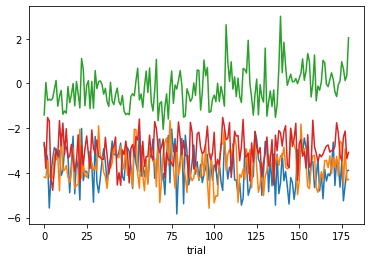

In [96]:
conform_data = csp.transform(test)
print(np.shape(conform_data))
plt.xlabel('trial')
plt.plot(conform_data)

In [97]:
from sklearn.model_selection import cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(conform_data, label, test_size=0.2,random_state=42)
model =SVC(kernel='linear')
scores = cross_val_score(model, conform_data, label)
# model.fit(X_train,Y_train)
# print(model.score(X_train, Y_train))
# print(model.score(X_test, Y_test))

print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.72222222 0.55555556 0.69444444 0.55555556 0.83333333]
Average score: 0.6722222222222223


In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(conform_data, label, test_size=0.2,random_state=42)
model =SVC(kernel='linear')
model.fit(X_train,Y_train)
print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

params = {
    'C':[1, 10, 10],
    'kernel':['rbf', 'linear', 'poly'],
    'gamma':np.linspace(0.01, 1.0, 10)
}
grid = GridSearchCV(model, params,scoring="accuracy", cv=5)

grid.fit(X_train, Y_train)
print(grid.best_score_)
print(grid.best_params_)

pred = grid.predict(X_test)
print(classification_report(Y_test, pred))


0.6875
0.6388888888888888
0.7285714285714285
{'C': 10, 'gamma': 0.12, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.57      0.72      0.63        18

    accuracy                           0.58        36
   macro avg       0.59      0.58      0.58        36
weighted avg       0.59      0.58      0.58        36

